GROUP N

Scope 5

                             OLS Regression Results                             
Dep. Variable:     snp_close_pct_change   R-squared:                       0.459
Model:                              OLS   Adj. R-squared:                  0.456
Method:                   Least Squares   F-statistic:                     164.0
Date:                  Mon, 24 Apr 2023   Prob (F-statistic):           5.73e-77
Time:                          11:45:44   Log-Likelihood:                 826.67
No. Observations:                   584   AIC:                            -1645.
Df Residuals:                       580   BIC:                            -1628.
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const       

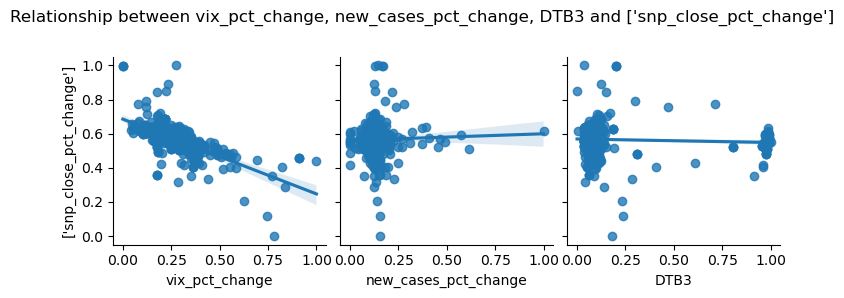

In [ ]:
import numpy as np, pandas as pd
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.gridspec as gridspec
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 50)

# covid

def clean_covid():
    covid = pd.read_csv("../data/covid.csv")
    covid = covid[['new_cases','formatted_date']]
    covid = covid.query('(formatted_date >= 20200101) & (formatted_date <= 20211231)')

    covid = covid.set_index('formatted_date')
    covid.index = pd.to_datetime(covid.index, format='%Y%m%d')
    return covid

# snp
def clean_snp():
    snp = pd.read_csv("../data/snp.csv")
    snp = snp[["formatted_date","SnP_Close","SnP_Volume","VIX"]]

    snp["snp_close_pct_change"] = snp["SnP_Close"].pct_change()
    snp["snp_volume_pct_change"] = snp["SnP_Volume"].pct_change()
    snp["vix_pct_change"] = snp["VIX"].pct_change()
    snp.fillna(0, inplace=True)

    snp = snp[['formatted_date','snp_close_pct_change','snp_volume_pct_change','vix_pct_change']]

    snp = snp.set_index('formatted_date')
    snp.index = pd.to_datetime(snp.index, format='%Y%m%d')
    return snp


# econ
def clean_econ():
    econ = pd.read_csv("../data/econ_factors.csv")

    econ.drop("DATE",axis=1, inplace=True)
    econ["RSXFS"] = econ["RSXFS"].apply(lambda x: x.replace("B", ""))
    econ["RSXFS"] = econ["RSXFS"].astype(float)


    econ["monthly_gdp"] = econ["monthly_gdp"].apply(lambda x: x.replace("T", ""))
    econ["monthly_gdp"] = econ["monthly_gdp"].astype(float)



    # monthly data interpolation
    econ = econ.set_index('formatted_date')
    econ.index = pd.to_datetime(econ.index, format='%Y%m%d')
    econ_daily = econ.resample('D').interpolate()
    return econ_daily

# merging

feature_df = pd.merge(clean_covid(), clean_snp(), on='formatted_date', how='left')
feature_df = pd.merge(feature_df, clean_econ(), on='formatted_date', how='left')
feature_df.fillna(method='ffill', inplace=True)

# scale every column using min-max scaler
scaler = MinMaxScaler()
feature_df[feature_df.columns] = scaler.fit_transform(feature_df[feature_df.columns])

feature_df

lagcov = clean_covid().shift(0).dropna()
temp_snp = clean_snp()[["snp_close_pct_change","vix_pct_change"]]

iter3_df = pd.merge(lagcov,temp_snp, how="left", on="formatted_date")
iter3_df.fillna(method="ffill",inplace = True)
iter3_df["new_cases_pct_change"] = iter3_df["new_cases"].pct_change()
iter3_df["new_cases_pct_change"].fillna(0, inplace=True)


iter3_df.replace([np.inf, -np.inf], np.nan, inplace=True)
iter3_df.fillna(method="ffill", inplace=True)
iter3_df.fillna(0, inplace=True)

scaler = MinMaxScaler()
iter3_df[iter3_df.columns] = scaler.fit_transform(iter3_df[iter3_df.columns])
iter3_df

wti = pd.read_csv("../data/WTI.csv")
tbill = pd.read_csv("../data/3MTbill.csv")
saving = pd.read_csv("../data/PSAVERT.csv")

# tbill
tbill = tbill[(tbill["DATE"]>="2019-12-31")&(tbill["DATE"]<="2022-01-01")]
tbill.replace(".", np.nan, inplace=True)
tbill["DTB3"].fillna(method="ffill",inplace=True)
tbill['DATE'] = pd.to_datetime(tbill['DATE'], format='%Y-%m-%d')

# covid
covid = clean_covid()

# wti
wti['Day'] = pd.to_datetime(wti['Day'], format='%m/%d/%Y')
wti['DATE'] = wti['Day'].dt.strftime('%Y-%m-%d')
wti['DATE'] = pd.to_datetime(wti['DATE'], format='%Y-%m-%d')
wti = wti[(wti["DATE"]>="2019-12-31")&(wti["DATE"]<="2022-01-01")]
wti.drop("Day",axis=1,inplace= True)
wti.rename({"Price":"wti"},axis=1,inplace=True)

added_feature_iter3_df = pd.merge(covid,tbill,left_index=True, right_on="DATE",how="outer")
added_feature_iter3_df['DATE'] = pd.to_datetime(added_feature_iter3_df['DATE'], format='%Y-%m-%d')
added_feature_iter3_df = pd.merge(added_feature_iter3_df, wti,left_on="DATE",right_on="DATE",how="outer")
added_feature_iter3_df.sort_values(by="DATE",inplace=True)
added_feature_iter3_df.fillna(method="ffill",inplace=True)
added_feature_iter3_df = added_feature_iter3_df.iloc[1:,1:]
added_feature_iter3_df.set_index("DATE",inplace=True)
added_feature_iter3_df[added_feature_iter3_df.columns] = scaler.fit_transform(added_feature_iter3_df[added_feature_iter3_df.columns])

iter3_final_df = pd.merge(added_feature_iter3_df, iter3_df, left_index=True, right_index=True)
iter3_final_df = pd.merge(iter3_final_df,clean_econ(),left_index=True,right_index=True)

def running_regression(df, xcol, ycol):
    X = df[xcol]

    X = sm.add_constant(X)

    y = df[ycol]

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Create a linear regression model
    model = sm.OLS(y_train, X_train)

    results = model.fit()
    print(results.summary())

    y_pred = results.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean squared error: {mse:.2f}")

    r2 = r2_score(y_test, y_pred)
    print(f"R-squared score: {r2:.2f}")

xcol1 = ['vix_pct_change','new_cases_pct_change','DTB3']
ycol1 = ['snp_close_pct_change']
running_regression(iter3_final_df,xcol1,ycol1)


def visualize_regression(df, xcols, ycol):

    sns.pairplot(data=df, x_vars=xcols, y_vars=[ycol], kind="reg")
    plt.suptitle(f"Relationship between {', '.join(xcols)} and {ycol}", y=1.15)
    
    plt.show()

visualize_regression(iter3_final_df, xcol1, ycol1)



Scope 2

                            OLS Regression Results                            
Dep. Variable:         vix_pct_change   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     173.5
Date:                Mon, 24 Apr 2023   Prob (F-statistic):           2.75e-80
Time:                        11:45:46   Log-Likelihood:                 671.48
No. Observations:                 584   AIC:                            -1335.
Df Residuals:                     580   BIC:                            -1317.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.7743 

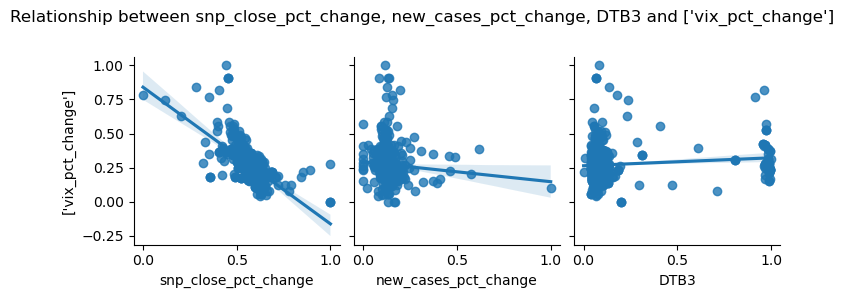

In [ ]:
xcol2 = ['snp_close_pct_change','new_cases_pct_change','DTB3']
ycol2 = ['vix_pct_change']
running_regression(iter3_final_df,xcol2,ycol2)

visualize_regression(iter3_final_df, xcol2, ycol2)

Scope 3

In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from os import listdir
from os.path import isfile, join
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split


data_path = '../data/'
import_csv_name = [f for f in listdir(data_path) if (isfile(join(data_path, f))) and (f.endswith('.xlsx'))]

stock_df = pd.DataFrame()

for iter in range(len(import_csv_name)):
    df = pd.read_excel(data_path + import_csv_name[iter])
    df["sector"] = import_csv_name[iter].split('.')[0].replace(" ","")
    required_columns = [item for item in df.columns  if "(SPX Index)" not in item]
    temp_sector_df = df[required_columns]
    temp_sector_df.columns = [item.split('\n')[0] for item in temp_sector_df.columns]
    stock_df = pd.concat([stock_df, temp_sector_df], axis=0, ignore_index=True)
    
stock_df["Date"] = stock_df["Date"].apply(lambda x: x.strftime('%Y%m%d'))
stock_df.fillna(method="ffill",inplace=True)
stock_df.columns = [item.replace(" ","") for item in stock_df.columns]


# scale every column using min-max scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
stock_df[stock_df.columns[1:-1]] = scaler.fit_transform(stock_df[stock_df.columns[1:-1]])

# oen hot encoding for sector
stock_df = pd.get_dummies(stock_df, columns=["sector"])
stock_df['Date'] = pd.to_datetime(stock_df['Date'], format='%Y%m%d')

covid = pd.read_csv("../data/covid/covid.csv")
covid = covid[["formatted_date","new_cases"]]
covid[covid.columns[1:]] = scaler.fit_transform(covid[covid.columns[1:]])
covid['formatted_date'] = pd.to_datetime(covid['formatted_date'], format='%Y%m%d')

# Create lagged version
covid['new_cases_lagged'] = covid['new_cases'].shift(1)
covid["new_cases_lagged"] = covid["new_cases_lagged"].fillna(0)

merged_df = stock_df.merge(covid, left_on='Date', right_on='formatted_date', how='inner')
merged_df.drop(columns=['formatted_date'], inplace=True)

X = merged_df[['new_cases_lagged', 'PriceEarningsRatio', 'RSI14Day',
               'sector_CommunicationServices', 'sector_ConsumerDiscretion',
               'sector_ConsumerStaple', 'sector_Energy', 'sector_Financial',
               'sector_HealthCare', 'sector_IT', 'sector_Industrial',
               'sector_Material', 'sector_RealEstate', 'sector_Utilities']]

X = sm.add_constant(X)

y = merged_df[['ReturnonCapital']]


train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model = sm.OLS(y_train, X_train)

results = model.fit()

print(results.summary())

y_pred = results.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse:.2f}")

r2 = r2_score(y_test, y_pred)
print(f"R-squared score: {r2:.2f}")


                            OLS Regression Results                            
Dep. Variable:        ReturnonCapital   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     1492.
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        11:45:51   Log-Likelihood:                 6610.3
No. Observations:                6058   AIC:                        -1.319e+04
Df Residuals:                    6044   BIC:                        -1.310e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

Scope 4

In [ ]:
import pandas as pd

df_fred_gdp = pd.read_csv('../data/FRED/GDP.csv') # GDP GROWTH RATE
df_fred_uer = pd.read_csv('../data/FRED/UNRATE.csv') # UNEMPLOMENT RATE
df_fred_ipi = pd.read_csv('../data/FRED/INDPRO.csv') # IND. PROD. RATE
df_fred_fed = pd.read_csv('../data/FRED/FEDFUNDS.csv') # INTEREST RATE
df_fred_cpi = pd.read_csv('../data/FRED/CPIAUCSL.csv') # INFLATION RATE

# Raw GDP data is quarterly.
df_fred_gdp.head()

def fill_date(date, x):
    if x in [1, 2]:
        date = date.split('/')
        month = str(int(date[1]) + x)
        return '/'.join([date[0], month, date[2]])

def fill_gdp(gdp_c, gdp_n, x):
    if x in [1, 2]:
        return gdp_c + (gdp_n - gdp_c) * (x/3)

def fill_growth(pct_p, pct_c):
    return (pct_c/pct_p - 1) * 100

for i in range(df_fred_gdp.shape[0] - 1):
    # Get dates between quarters.
    qd1 = df_fred_gdp['DATE'][i]
    qd2 = fill_date(qd1, 1)
    qd3 = fill_date(qd1, 2)
    # Estimate monthly GDP.
    gdp_l = df_fred_gdp['GDP'][i]
    gdp_4 = df_fred_gdp['GDP'][i + 1]
    gdp_2 = fill_gdp(gdp_l, gdp_4, 1)
    gdp_3 = fill_gdp(gdp_l, gdp_4, 2)
    # Insert them all.
    df_fred_gdp.loc[i + 0.1] = qd2, gdp_2
    df_fred_gdp.loc[i + 0.2] = qd3, gdp_3

df_fred_gdp = df_fred_gdp.sort_index().reset_index(drop = True)

# Recalculate monthly GDP growth.
monthly_gdp_growth = [0]
for i in range(1, df_fred_gdp.shape[0]):
    last_year = df_fred_gdp['GDP'][i - 1]
    this_year = df_fred_gdp['GDP'][i]
    monthly_gdp_growth.append(fill_growth(last_year, this_year))

df_fred_gdp['GDPNOW'] = monthly_gdp_growth

# Filter dates between 2019/12/1 and 2021/12/1.
for i in range(df_fred_gdp.shape[0]):
    date = df_fred_gdp['DATE'][i].split('/')
    year = int(date[0])
    month = int(date[1])
    if year not in [2020, 2021] and month != 12:
        df_fred_gdp = df_fred_gdp.drop(i, axis = 0)

df_fred_gdp = df_fred_gdp.reset_index(drop = True)
df_fred_gdp.head()

df_econ = df_fred_gdp.copy()
df_econ = df_econ.join(df_fred_uer.iloc[:, [1]])
df_econ = df_econ.join(df_fred_ipi.iloc[:, [1]])
df_econ = df_econ.join(df_fred_fed.iloc[:, [1]])
df_econ = df_econ.join(df_fred_cpi.iloc[:, [1]])
df_econ.head()

df_econ.to_csv('../data/econ.csv')
df_covid = pd.read_csv('../data/us_covid.csv')[['date', 'new_cases']]

df_econ.to_csv('../data/econ.csv')
df_covid = pd.read_csv('../data/us_covid.csv')[['date', 'new_cases']]

# Record end of each month.
end = []
for i in range(df_covid.shape[0] - 1):
    this_month = df_covid['date'][i].split('-')[1]
    next_month = df_covid['date'][i + 1].split('-')[1]
    if this_month != next_month:
        end.append(df_covid['date'][i])
end.append(df_covid['date'][df_covid.shape[0] - 1])

# Sum to get monthly new cases.
monthly_new_cases = []
for i in range(df_covid.shape[0]):
    date = df_covid['date'][i]
    day = date.split('-')[0]

    if day == '01':
        sum = 0
    
    sum += df_covid['new_cases'][i]

    if date in end:
        monthly_new_cases.append(sum)

# Filter beginning of each month.
for i in range(df_covid.shape[0]):
    date = df_covid['date'][i]
    day = date.split('-')[0]
    if day != '01':
        df_covid = df_covid.drop(i, axis = 0)

df_covid['new_cases'] = monthly_new_cases
df_covid = df_covid.reset_index(drop = True)
df_covid.tail()

df = df_econ.iloc[1:, [0]]
df.index -= 1

df['COVID'] = df_covid.iloc[:, [1]]

df_lag_econ = df_econ.iloc[:-1, 2:]
df_adv_econ = df_econ.iloc[1:, 2:]
df_adv_econ.index -= 1

df = df.join(df_lag_econ)
df = df.rename(columns = {'GDPNOW': 'LAG_GDPNOW',
                          'UNRATE': 'LAG_UNRATE',
                          'INDPRO': 'LAG_INDPRO',
                          'FEDFUNDS': 'LAG_FEDFUNDS',
                          'CPIAUCSL': 'LAG_CPI'})

df = df.join(df_adv_econ - df_lag_econ)
df = df.rename(columns = {'GDPNOW': 'DIR_GDPNOW',
                          'UNRATE': 'DIR_UNRATE',
                          'INDPRO': 'DIR_INDPRO',
                          'FEDFUNDS': 'DIR_FEDFUNDS',
                          'CPIAUCSL': 'DIR_CPI'})

df.tail(12)

def classify(x):
    if x < 0:
        return 0 # Decreases.
    return 1 # Increases.

for i in range(df.shape[0]):
    for j in df.columns[7:]:
        df.at[i, j] = classify(df[j][i])

df.to_csv('../out/scope_3.csv')
df.tail(12)

from sklearn import preprocessing

# min-max normalization
df_scale_min_max = preprocessing.MinMaxScaler().fit_transform(df.loc[:, df.columns == 'COVID'])
df_scale_min_max = pd.DataFrame(df_scale_min_max, columns = ['COVID'])

# Z-score normalization
df_scale_z_score = preprocessing.StandardScaler().fit_transform(df.loc[:, df.columns == 'LAG_GDPNOW'])
df_scale_z_score = pd.DataFrame(df_scale_z_score, columns = ['LAG_GDPNOW'])

df['COVID'] = df_scale_min_max
df.tail(12)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Separate features and labels.
X, y = df[df.columns[1:7]], df[df.columns[7:]].values

# Split x and y into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 4)
print('Training cases: %d\nTest cases: %d' % (X_train.shape[0], X_test.shape[0]))

import numpy as np

def covid_econ_pair(df, i):
    return df.iloc[:, [0]].join(df.iloc[:, [i + 1]])

# Train a logistic regression model for each x and y.
reg = 0.01

predictions = []
for i in range(len(y[0])):
    X_feat = covid_econ_pair(X_train, i)
    y_feat = y_train[:, i]
    model = LogisticRegression(C = 1/reg, solver = "liblinear").fit(X_feat, y_feat)
    pred = model.predict(covid_econ_pair(X_test, i))
    print('Label Col. Name: ', df.columns[7:][i])
    print('Predicted labels:', pred)
    print('Actual labels:   ', y_test[:, i])
    predictions.append(pred)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def eval(test, pred):
    # Print the confusion matrix.
    matrix = confusion_matrix(test, pred)
    print(matrix)

    tp = matrix[1][1]
    fp = matrix[0][1]
    fn = matrix[1][0]
    tn = matrix[0][0]

    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    prec = tp / (tp + fp)

    print('TP =', tp, 'FP =', fp, '\nFN =', fn, 'TN =', tn)
    print('Sensitivity =', round(sens, 3))
    print('Specificity =', round(spec, 3))
    print('Precision =', round(prec, 3))
    print()

titles = ['GDP Growth Nowcasted by GDPNow',
          'Unemployment Rate',
          'Industrial Production',
          'Federal Funds Effective Rate',
          'Consumer Price Index']

for i in range(len(y[0])):
    print(titles[i])
    eval(y_test[:, i], predictions[i])

## vizualize this !!


Training cases: 18
Test cases: 6
Label Col. Name:  DIR_GDPNOW
Predicted labels: [0. 0. 0. 1. 0. 0.]
Actual labels:    [0. 0. 0. 0. 0. 1.]
Label Col. Name:  DIR_UNRATE
Predicted labels: [1. 0. 1. 1. 0. 0.]
Actual labels:    [0. 0. 0. 1. 0. 0.]
Label Col. Name:  DIR_INDPRO
Predicted labels: [1. 1. 1. 1. 0. 1.]
Actual labels:    [1. 1. 0. 0. 1. 1.]
Label Col. Name:  DIR_FEDFUNDS
Predicted labels: [1. 1. 0. 1. 1. 1.]
Actual labels:    [1. 1. 1. 0. 1. 1.]
Label Col. Name:  DIR_CPI
Predicted labels: [1. 1. 1. 1. 1. 1.]
Actual labels:    [1. 1. 1. 0. 1. 1.]
GDP Growth Nowcasted by GDPNow
[[4 1]
 [1 0]]
TP = 0 FP = 1 
FN = 1 TN = 4
Sensitivity = 0.0
Specificity = 0.8
Precision = 0.0

Unemployment Rate
[[3 2]
 [0 1]]
TP = 1 FP = 2 
FN = 0 TN = 3
Sensitivity = 1.0
Specificity = 0.6
Precision = 0.333

Industrial Production
[[0 2]
 [1 3]]
TP = 3 FP = 2 
FN = 1 TN = 0
Sensitivity = 0.75
Specificity = 0.0
Precision = 0.6

Federal Funds Effective Rate
[[0 1]
 [1 4]]
TP = 4 FP = 1 
FN = 1 TN = 0
Sensi

Scope 5

C:\Users\maria\AppData\Local\Temp\ipykernel_564\4103885493.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_data_df['formatted_date'] = pd.to_datetime(covid_data_df['formatted_date'], format='%Y%m%d')
C:\Users\maria\AppData\Local\Temp\ipykernel_564\4103885493.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_data_df['formatted_date'] = pd.to_datetime(covid_data_df['formatted_date'], format='%Y%m%d')


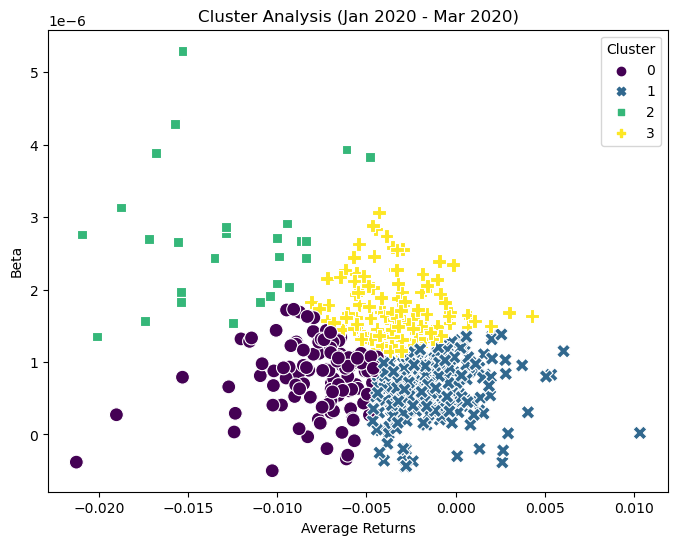

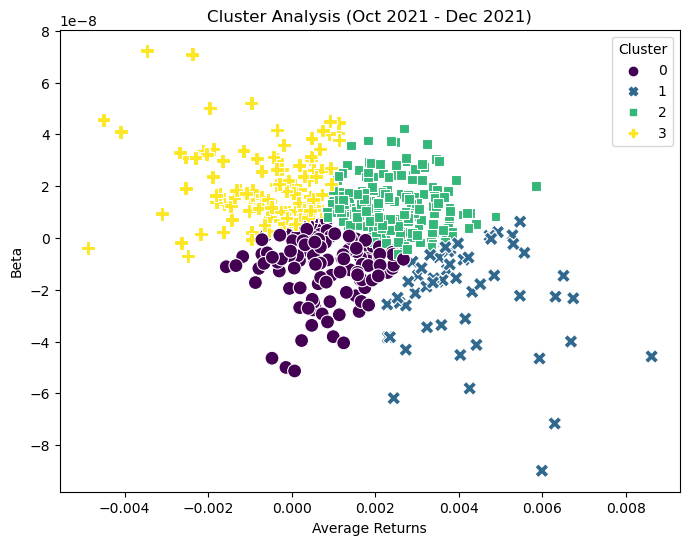

Pre-COVID Centroids:
          Avg_Returns          Beta
Cluster                           
0          -0.007610  7.972136e-07
1          -0.001313  6.390166e-07
2          -0.012859  2.686672e-06
3          -0.003364  1.704681e-06
Pre-COVID Scatter Distribution:
 {0: 0.0008218511175911126, 1: 0.0010659866831348105, 2: 0.0004708083826251387, 3: 0.0005972094861254924}
Post-COVID Centroids:
          Avg_Returns          Beta
Cluster                           
0           0.000818 -1.021262e-08
1           0.004164 -2.181448e-08
2           0.002390  1.250830e-08
3          -0.000585  2.013074e-08
Post-COVID Scatter Distribution:
 {0: 0.00010183654676204276, 1: 0.00010056803845198826, 2: 0.0001609448714694218, 3: 0.00017206751472508992}
now cluster 0
Financials                0.271186
Consumer Discretionary    0.194915
Industrials               0.135593
Information Technology    0.093220
Real Estate               0.084746
Communication Services    0.067797
Energy                    0.059

c:\Users\maria\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


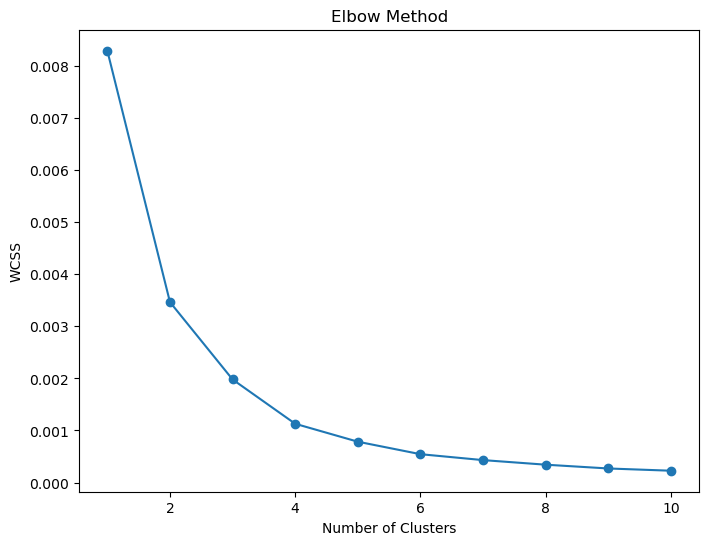

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

result_df = pd.read_csv("../out/stock_data.csv")

covid_data = pd.read_excel("../data/us_covid.xlsx")
covid_data = covid_data[["formatted_date","new_cases"]]

stock_prices = result_df.pivot(index='Date', columns='ticker', values='Close')
stock_return = stock_prices.pct_change()

#drop these companies due to insufficient data
stock_return = stock_return.drop(['OTIS', 'CARR', 'OGN'], axis=1)

# Filter the stock_return DataFrame for each time frame
stock_return_pre = stock_return.loc['20200101':'20200331']
stock_return_post = stock_return.loc['20211001':'20211231']

# Filter the covid_data DataFrame for each time frame
covid_data_pre = covid_data.loc[(covid_data['formatted_date'] >= 20200101) & (covid_data['formatted_date'] <= 20200331)]
covid_data_post = covid_data.loc[(covid_data['formatted_date'] >= 20211001) & (covid_data['formatted_date'] <= 20211231)]

# Calculate beta for each stock in both time frames
def calculate_beta(stock_return_df, covid_data_df):
    # Align the dates between stock_return_df and covid_data_df
    stock_return_df = stock_return_df.reset_index()
    stock_return_df['Date'] = pd.to_datetime(stock_return_df['Date'], format='%Y%m%d')
    covid_data_df['formatted_date'] = pd.to_datetime(covid_data_df['formatted_date'], format='%Y%m%d')

    merged_df = stock_return_df.merge(covid_data_df, left_on='Date', right_on='formatted_date', how='inner')

    # Calculate the covariance between stock returns and new_cases
    covariances = {}
    for col in merged_df.columns[1:-2]:
        covariances[col] = merged_df[col].cov(merged_df['new_cases'])

    # Calculate the variance of new_cases
    variance = merged_df['new_cases'].var()

    # Calculate beta
    beta = {ticker: cov / variance for ticker, cov in covariances.items()}

    return beta

beta_pre = calculate_beta(stock_return_pre, covid_data_pre)
beta_post = calculate_beta(stock_return_post, covid_data_post)



def cluster_analysis(stock_return_df, beta):
    # Calculate the average stock returns
    avg_returns = stock_return_df.mean()

    # Convert the beta dictionary to a DataFrame
    beta_df = pd.DataFrame(list(beta.items()), columns=['Ticker', 'Beta']).set_index('Ticker')

    # Combine average stock returns and beta values into a single DataFrame
    data = pd.concat([avg_returns, beta_df], axis=1)
    data.columns = ['Avg_Returns', 'Beta']

    # Fill NaN values with 0
    data = data.fillna(0)

    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    # Cluster the data
    kmeans = KMeans(n_clusters=4, random_state=0).fit(scaled_data)

    # Add the cluster labels to the original data
    data['Cluster'] = kmeans.labels_

    return data

clustered_data_pre = cluster_analysis(stock_return_pre, beta_pre)
clustered_data_post = cluster_analysis(stock_return_post, beta_post)


# Plot the clusters
def plot_clusters(clustered_data, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=clustered_data, x='Avg_Returns', y='Beta', hue='Cluster', palette='viridis', style='Cluster', s=100)
    plt.title(title)
    plt.xlabel('Average Returns')
    plt.ylabel('Beta')
    plt.show()

plot_clusters(clustered_data_pre, 'Cluster Analysis (Jan 2020 - Mar 2020)')
plot_clusters(clustered_data_post, 'Cluster Analysis (Oct 2021 - Dec 2021)')

stock_industry = pd.read_csv("../data/stock_detail.csv")
stock_industry = stock_industry.iloc[:,:3]

pre_cov_cluster_df = pd.merge(clustered_data_pre,stock_industry,how="left",left_index= True, right_on= "Symbol")
psot_cov_cluster_df = pd.merge(clustered_data_post,stock_industry,how="left",left_index= True, right_on= "Symbol")

def cluster_analysis_with_centroids_and_scatter(clustered_data):
    # Calculate the centroids of each cluster
    centroids = clustered_data.groupby('Cluster').mean()[['Avg_Returns', 'Beta']]

    # Calculate the scatter distribution for each cluster
    scatter_distribution = {}
    for cluster_label in centroids.index:
        cluster_points = clustered_data[clustered_data['Cluster'] == cluster_label][['Avg_Returns', 'Beta']]
        centroid = centroids.loc[cluster_label]
        squared_distances = ((cluster_points - centroid) ** 2).sum(axis=1)
        scatter_distribution[cluster_label] = squared_distances.sum()

    return centroids, scatter_distribution

pre_centroids, pre_scatter_distribution = cluster_analysis_with_centroids_and_scatter(clustered_data_pre)
post_centroids, post_scatter_distribution = cluster_analysis_with_centroids_and_scatter(clustered_data_post)

print("Pre-COVID Centroids:\n", pre_centroids)
print("Pre-COVID Scatter Distribution:\n", pre_scatter_distribution)

print("Post-COVID Centroids:\n", post_centroids)
print("Post-COVID Scatter Distribution:\n", post_scatter_distribution)

for iters in range(0,4):
    print(f"now cluster {iters}")
    temp_cluster_gpX_df = pre_cov_cluster_df.query("Cluster==@iters")["Sector"].value_counts()
    print(temp_cluster_gpX_df/(temp_cluster_gpX_df.sum()))
    print(temp_cluster_gpX_df.sum())

from sklearn.cluster import KMeans

# Calculate WCSS for different numbers of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(cluster_analysis(stock_return_pre, beta_pre).drop('Cluster', axis=1))
    wcss.append(kmeans.inertia_)

# Plot the WCSS values
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# the interpretation of this is that we should choose 4 cluster as after that number the wcss does not decrease anymore significantly
